# Program - Plot RF01 & RF02 LWP for SCM, LES, and OBS

**Content:**

- Open and Read SCM netCDF files
- Open and Read LES netCDF files
- Plot XY time series

**Author**: Yi-Hsuan Chen (yihsuan@umich.edu)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import xarray as xr
import io, os, sys, types
import cftime

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
import read_data_big as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation"

ERROR 1: PROJ: proj_create_from_database: Open of /lfs/opt/anaconda3/share/proj failed


# Read data

## Read RF01 LES intercomparison data

In [2]:
#--- Read RF01 LES intercomparison data
datapath_les_comp = "/lfs/home/yihsuanc/data/data.LES/DYCOMS2_RF01.LES_intercomparison/"
fname_les_comp = datapath_les_comp+"/"+"gcss7.nc"
ds_les_rf01_comp = xr.open_dataset(fname_les_comp)

les_rf01_lwp_mean = ds_les_rf01_comp.lwp_bar[0,:]  # units: g/m2
les_rf01_lwp_min = ds_les_rf01_comp.lwp_bar[2,:]
les_rf01_lwp_max = ds_les_rf01_comp.lwp_bar[3,:]
les_rf01_lwp_1qrtl = ds_les_rf01_comp.lwp_bar[4,:]
les_rf01_lwp_3qrtl = ds_les_rf01_comp.lwp_bar[5,:]

les_rf01_tt = ds_les_rf01_comp.time[:]/3600  # in hours

## Read RF02 LES intercomparison data

In [3]:
#--- Read RF02 LES intercomparison data
datapath_les_comp = "/lfs/home/yihsuanc/data/data.LES/DYCOMS2_RF02.LES_intercomparison/"
fname_les_comp = datapath_les_comp+"/"+"BLCWG_DYCOMS-II_RF02.scalars.nc"
ds_les_rf02_comp = xr.open_dataset(fname_les_comp)

dr=1
sed=1
varname1='lwp'
tt1=0
tt2=72

les_rf02_lwp_max = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].max(dim='group')    # units: g/m2
les_rf02_lwp_min = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].min(dim='group')
les_rf02_lwp_med = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].median(dim='group'),
les_rf02_lwp_3qrtl = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].quantile(0.75, dim='group')
les_rf02_lwp_1qrtl = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].quantile(0.25, dim='group')
les_rf02_lwp_mean = ds_les_rf02_comp.get(varname1)[:,dr, sed, tt1:tt2].mean(dim='group')
les_rf02_tt = np.arange(0, tt2*300, 300) / 3600  # hours


#ds_les_rf02_comp
#les_rf02_tt

## Read SCM data

In [4]:
datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/"

files_scm = {
    "rf01_tpdf":datapath+"scm_taiesm1.dycomsrf01_yhc0509.aeroIC.macrop_tpdf/run/scm_taiesm1.dycomsrf01_yhc0509.aeroIC.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    "rf02_tpdf":datapath+"scm_taiesm1.dycomsrf02_yhc0509.aeroIC.macrop_tpdf/run/scm_taiesm1.dycomsrf02_yhc0509.aeroIC.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    #"rf01_tpdf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc", 
    #"rf01_updf": datapath+"q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf01.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
    #"rf02_tpdf": datapath+"q2_scm_taiesm1.dycomsrf02.psflx.macrop_tpdf/run/q2_scm_taiesm1.dycomsrf02.psflx.macrop_tpdf.cam.h0.1999-07-11-00000.nc",
    #"rf02_updf": datapath+"q2_scm_taiesm1.dycomsrf02.psflx.macrop_updf/run/q2_scm_taiesm1.dycomsrf02.psflx.macrop_updf.cam.h0.1999-07-11-00000.nc",
}

ds_scm_rf01 = xr.open_dataset(files_scm["rf01_tpdf"])
ds_scm_rf02 = xr.open_dataset(files_scm["rf02_tpdf"])

scm_rf01_lwp = yhc.unit_convert (ds_scm_rf01['TGCLDLWP'][:,0,0])
scm_rf01_tt = np.arange(0, len(ds_scm_rf01.time)) # hours

scm_rf02_lwp = yhc.unit_convert (ds_scm_rf02['TGCLDLWP'][:,0,0])
scm_rf02_tt = np.arange(0, len(ds_scm_rf02.time)) # hours
#scm_rf01_lwp

#len(scm_rf01_tt)

## Read LWP OBS

In [5]:
lwp_obs_rf01 = 75.4 # Stevens et al. (2007)
lwp_obs_rf02 = 137.4 # Stevens et al. (2007)

tt_obs_rf01 = [0.,4.]
tt_obs_rf02 = [0.,4.]

## Read hindcast 

### select_region_ds

In [6]:
##################
##################
##################
def select_region_ds(ds,
                  region="lat_lon",
                  lat=None, lon=None, 
                 ):

    func_name = "select_ds_region"
    
    #--- given the lat/lon range of a region
    if (region == "NE_CA"):
        #lowerlon=235; upperlon=245; lowerlat=28; upperlat=35
        lowerlon=225; upperlon=250; lowerlat=24; upperlat=40

    elif (region == "DYCOMS"): 
        #--- reference: Eyeballing in Fig. 1 in Stevens et al. (2007, MWR)
        region_name = "DYCOMS (29.5-33N, 120-123.5W)"
        lowerlat =  29.5   # 29.5N
        upperlat =  33     # 33N
        lowerlon =  236.5  # 123.5W
        upperlon =  240    # 120W

    elif (region == "lat_lon"): 
        if lat is None or lon is None:
            error_msg = f"ERROR: function [{func_name}] needs lat [{lat}] and lon [{lon}] when region='lat_lon'"
            raise KeyError(error_msg)
    
    else:
        lowerlon=-1000; upperlon=1000; lowerlat=-1000; upperlat=1000

    #--- select for in the given region
    if (region == "lat_lon"):
        lat_index, lon_index = get_lat_lon_indexes(ds, lat, lon)
        ds_region = ds.isel(lat=lat_index, lon=lon_index)

    else:
        lon_slice = slice(lowerlon, upperlon)
        lat_slice = slice(lowerlat, upperlat)
        ds_region = ds.sel(lat=lat_slice, lon=lon_slice)
    
    return ds_region

##################
##################
##################
def get_lat_lon_indexes(ds, lat, lon):
    lat_index = abs(ds['lat'] - lat).argmin().item()
    lon_index = abs(ds['lon'] - lon).argmin().item()

    return lat_index, lon_index

### lat_lon_weighted_avg

In [7]:
import xarray as xr
import numpy as np

def lat_lon_weighted_avg(ds: xr.Dataset, lat_name: str = 'lat', lon_name: str = 'lon') -> xr.Dataset:
    """
    Compute the latitude-weighted average of an xarray.Dataset over lat and lon dimensions,
    only for variables that have both lat and lon in their coordinates.
    
    Parameters:
    ds (xr.Dataset): Input dataset with latitude and longitude dimensions.
    lat_name (str): Name of the latitude coordinate in the dataset.
    lon_name (str): Name of the longitude coordinate in the dataset.
    
    Returns:
    xr.Dataset: Dataset with lat/lon dimensions averaged using latitude weighting.
    """
    # Select only numeric variables that have both lat and lon as dimensions
    valid_vars = {
        var: ds[var] for var in ds.data_vars
        if np.issubdtype(ds[var].dtype, np.number) and {lat_name, lon_name}.issubset(ds[var].dims)
    }
    
    if not valid_vars:
        raise ValueError("No valid variables found with both lat and lon dimensions.")
    
    ds = xr.Dataset(valid_vars, coords=ds.coords)
    
    # Convert latitudes to radians for weighting
    lat_rad = np.deg2rad(ds[lat_name])
    
    # Compute latitude weights (cosine of latitude)
    weights = np.cos(lat_rad)
    
    # Normalize weights only over lat dimension
    weights /= weights.sum(dim=lat_name)
    
    # Compute weighted mean using dot product for efficiency
    weighted_mean = ds.weighted(weights).mean(dim=[lat_name, lon_name])
    
    return weighted_mean

### read_hindcast_lwp_tjiavg

In [8]:
def assign_ds_attrs(ds: xr.Dataset,
                    region, lat_values, lon_values):
    ds = ds.assign_attrs(
        avg_region=region,
        avg_lat=lat_values,
        avg_lon=lon_values,
    )
    return ds

###############
###############
###############
def select_ds_time_period(ds, start_str=None, end_str=None):
    """
    Selects data from a dictionary of xarray Datasets within a specified time period.

    Parameters:
        ds_dict (dict): A dictionary of xarray Datasets, where each dataset contains a 'time' coordinate in cftime.DatetimeNoLeap format.
        start_str (str): Start time in "YYYYMMDD_HHMMSS" format.
        end_str (str): End time in "YYYYMMDD_HHMMSS" format.

    Returns:
        dict: A dictionary of xarray Datasets within the specified time range.
    """

    # Assuming all datasets in ds_dict have the same time range, get the global time range from one of them
    time_min, time_max = ds.time.min(), ds.time.max()

    # Check if the start_str and end_str are provided
    if start_str:
        # Parse start time from "YYYYMMDD_HHMMSS" format
        start_time = cftime.DatetimeNoLeap(
            int(start_str[:4]),  # Year
            int(start_str[4:6]),  # Month
            int(start_str[6:8]),  # Day
            int(start_str[9:11]),  # Hour
            int(start_str[11:13]),  # Minute
            int(start_str[13:15])   # Second
        )

        # Validate start_time within dataset range
        if start_time < time_min or start_time > time_max:
            raise ValueError(f"start_str ({start_str}) is out of range: {time_min} to {time_max}")
    else:
        start_time = time_min  # Default to minimum time in dataset if start_str is not provided

    if end_str:
        # Parse end time from "YYYYMMDD_HHMMSS" format
        end_time = cftime.DatetimeNoLeap(
            int(end_str[:4]),  # Year
            int(end_str[4:6]),  # Month
            int(end_str[6:8]),  # Day
            int(end_str[9:11]),  # Hour
            int(end_str[11:13]),  # Minute
            int(end_str[13:15])   # Second
        )

        # Validate end_time within dataset range
        if end_time < time_min or end_time > time_max:
            raise ValueError(f"end_str ({end_str}) is out of range: {time_min} to {time_max}")
    else:
        end_time = time_max  # Default to maximum time in dataset if end_str is not provided

   # Check if end_time is greater than start_time
    if end_time < start_time:
        raise ValueError(f"end_time ({end_time}) cannot be earlier than start_time ({start_time})")
        
    # Apply the time selection to each dataset in the dictionary and return the updated dictionary
    ds_filtered = ds.sel(time=slice(start_time, end_time))

    return ds_filtered
                         
###############
###############
###############
def read_hindcast_lwp_tjiavg(icdate, target_date,
                  start_str=None, end_str=None,
                  varname = "TGCLDLWP", 
                  datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_hindcast/data.TaiESM1.July2001_hindcast02/run",
                  region="DYCOMS",
    ):

    #icdate = "20010704"
    #target_data = "2001-07-10"
    fname = f"yy_subset-hindcast02_2001July-taiesm1.F_2000_TAI.f09_f09.icdate_{icdate}.cam.h0_2d_1h.{target_date}-00000.nc"
    filename = datapath+"/"+fname

    ds = xr.open_dataset(filename)

    ds_subtime = select_ds_time_period (ds, start_str=start_str, end_str=end_str)
    ds_1d_time_latlon = select_region_ds(ds_subtime, region=region)
    
    lat_values = ds_1d_time_latlon['lat'].values.tolist()
    lon_values = ds_1d_time_latlon['lon'].values.tolist()

    if region != "lat_lon":        
        ds_1d_time_latlon = lat_lon_weighted_avg(ds_1d_time_latlon)
        ds_1d_time_latlon = assign_ds_attrs(ds_1d_time_latlon, region, lat_values, lon_values)

    lwp_ji_avg = yhc.unit_convert(ds_1d_time_latlon[varname])
    lwp_tji_avg = lwp_ji_avg.mean('time')
    
    return lwp_ji_avg, lwp_tji_avg
    #return ds, ds_1d_time_latlon, lwp_tji_avg

#-----------
# do_test
#-----------
do_test = "112"

if (do_test == "111"):
    icdate = "20010707"
    target_date = "2001-07-10"
    
    start_str=None ; end_str=None
    # RF01/02: 06-15 UTC. Supplement of Stevens (2003), table S2
    start_str = "20010710_080000" #YYYYMMDD_HHMMSS
    end_str   = "20010710_130000" #YYYYMMDD_HHMMSS
    #ds, ds_1d_time_latlon, lwp_tji_avg = read_hindcast_lwp_tjiavg(icdate, target_date, start_str=start_str, end_str=end_str)
    lwp_ji_avg, lwp_tji_avg = read_hindcast_lwp_tjiavg(icdate, target_date, start_str=start_str, end_str=end_str)
   
#ds_1d_time_latlon['TGCLDLWP'].mean('time')
#ds

### get lwp_hindcast_rf01

In [9]:
lwp_hindcast_rf01 = {}
#icdates = ["20010710", "20010709", "20010708", "20010707", "20010706"]
icdates = ["20010709", "20010708", "20010707", "20010706"]
target_date = "2001-07-10"

# RF01/02: 06-15 UTC. Supplement of Stevens (2003), table S2
start_str = "20010710_080000" #YYYYMMDD_HHMMSS
end_str   = "20010710_130000" #YYYYMMDD_HHMMSS

for icdate in icdates:
    lwp_ji_avg, lwp_tji_avg = read_hindcast_lwp_tjiavg(icdate, target_date, start_str=start_str, end_str=end_str)
    lwp_hindcast_rf01[icdate] = lwp_tji_avg.values

#lwp_hindcast_rf01

### get lwp_hindcast_rf02

In [10]:
lwp_hindcast_rf02 = {}
#icdates = ["20010711","20010710", "20010709", "20010708", "20010707"]
icdates = ["20010710", "20010709", "20010708", "20010707"]
target_date = "2001-07-11"

# RF01/02: 06-15 UTC. Supplement of Stevens (2003), table S2
start_str = "20010711_080000" #YYYYMMDD_HHMMSS
end_str   = "20010711_130000" #YYYYMMDD_HHMMSS

for icdate in icdates:
    lwp_ji_avg, lwp_tji_avg = read_hindcast_lwp_tjiavg(icdate, target_date, start_str=start_str, end_str=end_str)
    lwp_hindcast_rf02[icdate] = lwp_tji_avg.values

#lwp_hindcast_rf02

# Plot

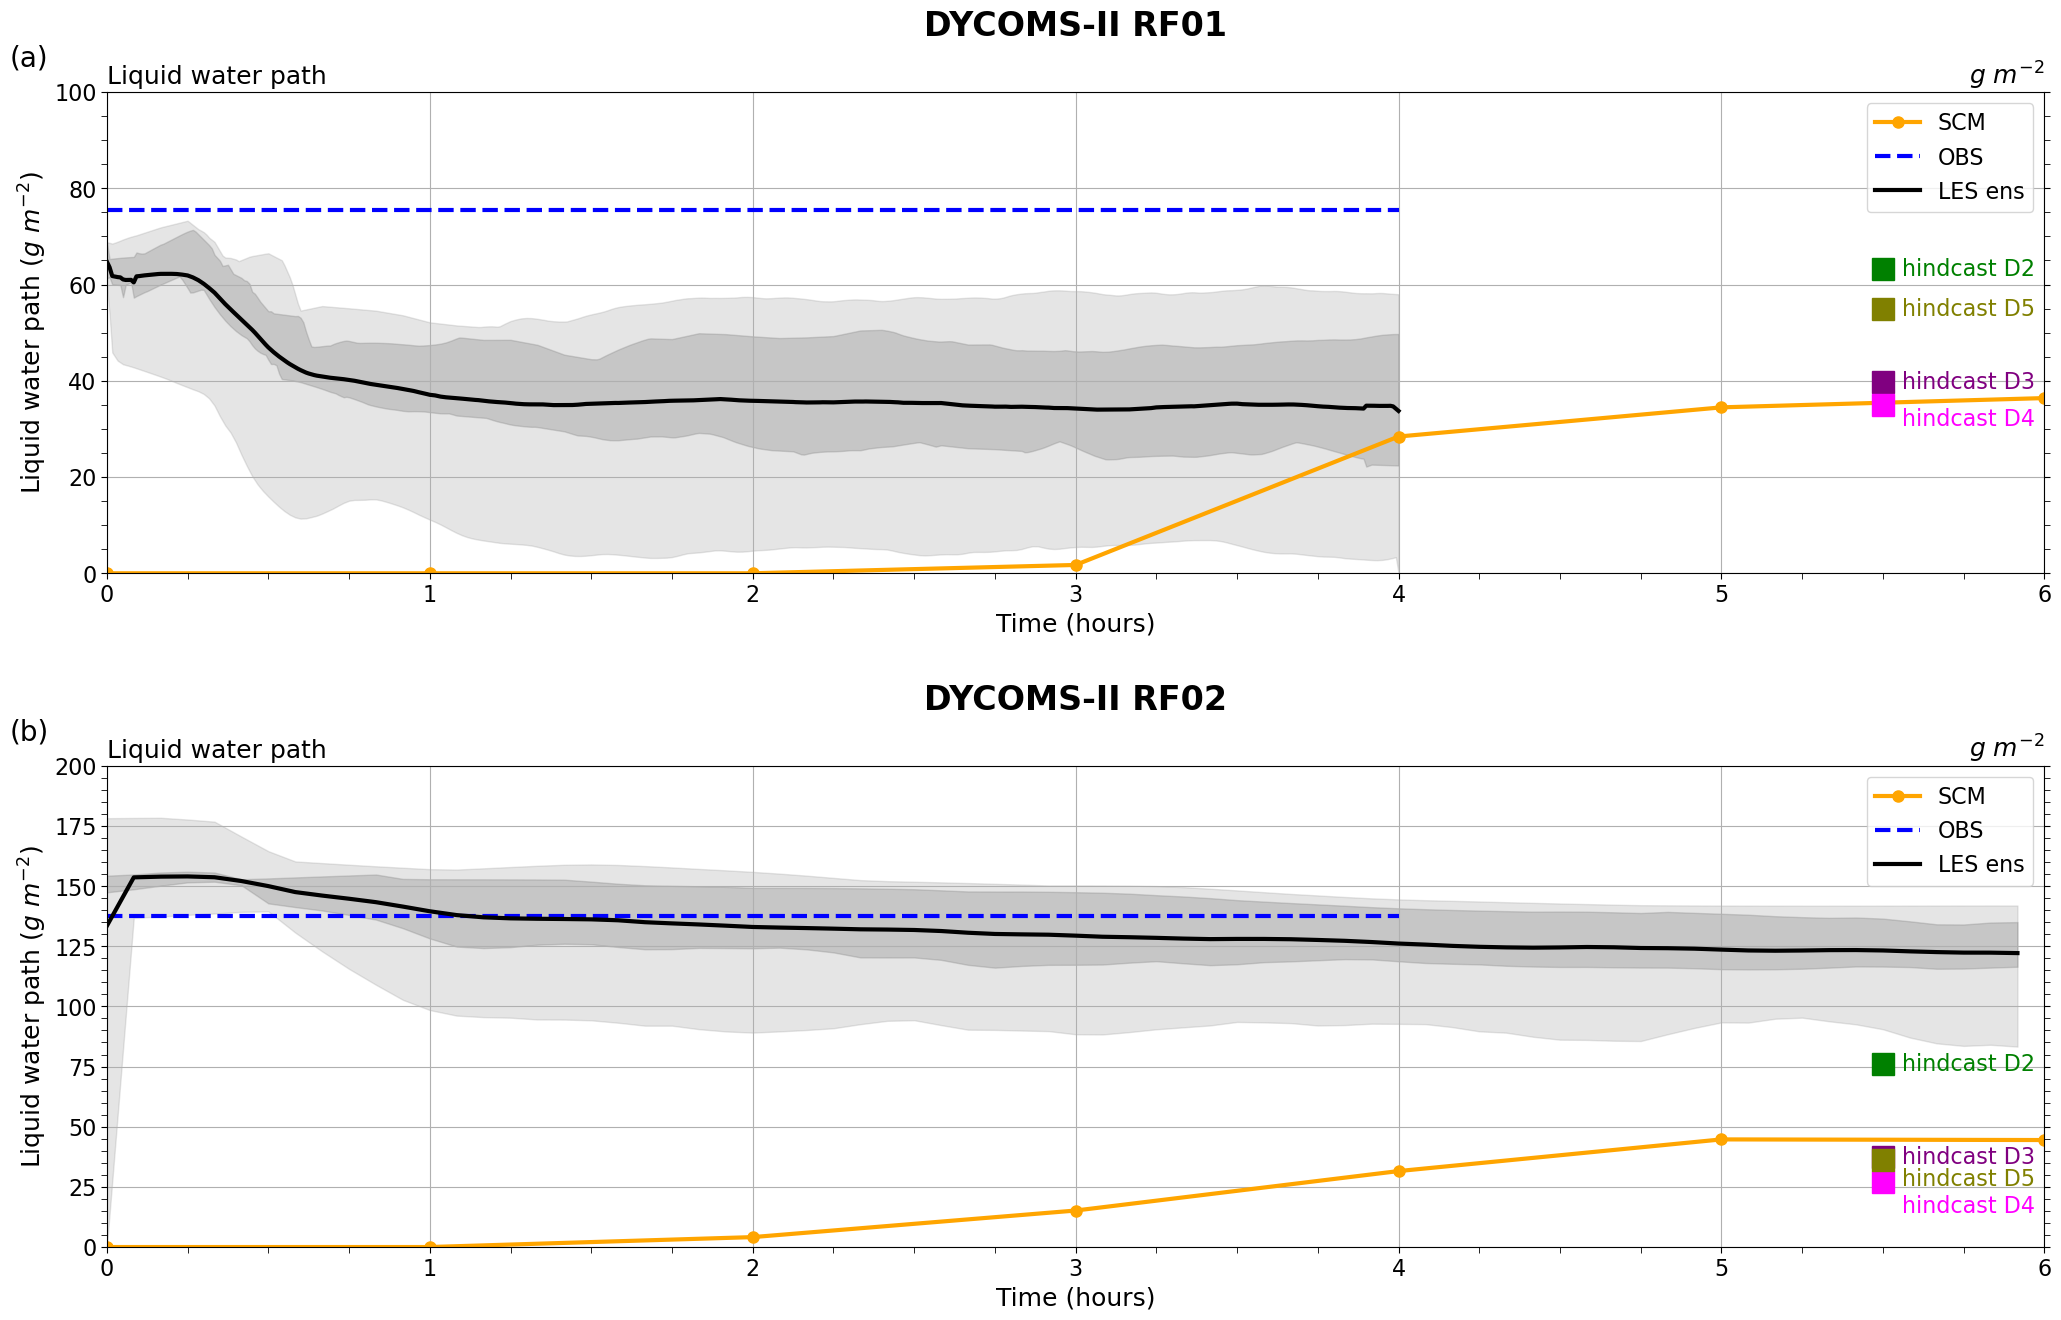

In [38]:
################
################
################
def plot_time_series_LWP_SCM_LES(ax, choice):

    if choice == "RF01":
        #--- LES intercomparison
        lwp_les_mean = les_rf01_lwp_mean
        lwp_les_min  = les_rf01_lwp_min
        lwp_les_max  = les_rf01_lwp_max
        lwp_les_1qrtl = les_rf01_lwp_1qrtl
        lwp_les_3qrtl = les_rf01_lwp_3qrtl
    
        tt_les = les_rf01_tt
    
        #--- SCM
        lwp_scm = scm_rf01_lwp
        tt_scm  = scm_rf01_tt
    
        #--- obs
        lwp_obs = lwp_obs_rf01
        tt_obs = tt_obs_rf01

        #--- hindcast
        lwp_hindcast = lwp_hindcast_rf01
        
        mainstring = "DYCOMS-II RF01"
        ylim = [0,100]
    
    elif choice == "RF02":
        #--- LES intercomparison
        lwp_les_mean = les_rf02_lwp_mean
        lwp_les_min  = les_rf02_lwp_min
        lwp_les_max  = les_rf02_lwp_max
        lwp_les_1qrtl = les_rf02_lwp_1qrtl
        lwp_les_3qrtl = les_rf02_lwp_3qrtl
    
        tt_les = les_rf02_tt
    
        #--- SCM
        lwp_scm = scm_rf02_lwp
        tt_scm  = scm_rf02_tt
    
        #--- obs
        lwp_obs = lwp_obs_rf02
        tt_obs = tt_obs_rf02

        #--- hindcast
        lwp_hindcast = lwp_hindcast_rf02
        
        mainstring = "DYCOMS-II RF02"
        ylim = [0,200]

    #--- share 
    linewidth = 3

    #--- plot SCM
    ax.plot (tt_scm, lwp_scm, 'orange', marker="o", markersize=8, linewidth=linewidth, label = "SCM")
    
    #--- plot obs
    ax.plot (tt_obs, [lwp_obs,lwp_obs], 'b--', linewidth=linewidth, label="OBS")

    #--- plot les mean
    ax.plot (tt_les, lwp_les_mean, 'k-', linewidth=linewidth, label = "LES ens")
    
    #--- plot color fill of min/max
    ax.fill_between( 
        tt_les, lwp_les_min, lwp_les_max,color='gray', alpha=0.2,
            )
    
    #--- plot color fill of 1st/3rd qrtl 
    ax.fill_between( 
        tt_les, lwp_les_1qrtl, lwp_les_3qrtl ,color='gray', alpha=0.3,
            )

    #--- plot hindcast
    tt_hindcast = 5.5

    # Sort the dictionary by date
    sorted_dates = sorted(lwp_hindcast.keys())
    lwp_values = [lwp_hindcast[date] for date in sorted_dates] # ["D2", "D3", "D4", "D5"]
    labels_hindcast = ["D2", "D3", "D4", "D5"]

    #target_labels = ["D3", "D5"]
    target_labels = labels_hindcast.copy()
    indices = [i for i, label in enumerate(labels_hindcast) if label in target_labels]
    selected_lwp = [lwp_values[i] for i in indices]

    # Labels
    #labels_hindcast = ["D3","D5"]
    #target_labels = ["Day-2","Day-3","Day-4","Day-5"]
    #labels_hindcast_plot = [f"{label} hindcast" for label in target_labels]

    target_labels = labels_hindcast.copy()
    labels_hindcast_plot = [f"hindcast {label}" for label in target_labels]
    
    #colors_hindcast = ["deepskyblue","limegreen","hotpink","magenta"]
    colors_hindcast = ["green","purple","magenta","olive"]
    
    for i, (val, label) in enumerate(zip(selected_lwp, labels_hindcast_plot)):
        #ax.plot(tt_hindcast, val, linestyle="None", marker="s", markersize=20, label=label, color=colors_hindcast[i])
        ax.plot(tt_hindcast, val, linestyle="None", marker="s", markersize=16, label=None, color=colors_hindcast[i])

        #--- adjust text Y value
        yval = val
        if choice=="RF01" and label=="Day-4 hindcast": yval = val-3
        if choice=="RF02" and label=="Day-4 hindcast": yval = val-10
        if choice=="RF02" and label=="Day-5 hindcast": yval = val-8
        if choice=="RF01" and label=="hindcast D4": yval = val-3
        if choice=="RF02" and label=="hindcast D4": yval = val-10
        if choice=="RF02" and label=="hindcast D5": yval = val-8
        
        ax.text(tt_hindcast+0.06, yval, label, fontsize=16, color=colors_hindcast[i], va='center')
    
    #--- adjust figures
    ax.legend(fontsize = 16, loc="upper right")
    ax.grid(True)
    ax.set_xlim(0,6)
    ax.set_ylim(ylim)

    fontsize_string = 18
    ax.set_title("Liquid water path", loc='left', fontsize = fontsize_string)
    ax.set_title(r"$g \ m^{-2}$", loc='right', fontsize = fontsize_string)
    ax.set_ylabel(r"Liquid water path ($g \ m^{-2}$)", fontsize = fontsize_string)
    ax.set_xlabel("Time (hours)", fontsize = fontsize_string)

    ax.tick_params(axis='both', which='both', direction='out', length=4, labelsize=16)  # This adds ticks to both axes
    #ax.tick_params(axis='x', which='both', top=True)  # Ticks on the top
    ax.tick_params(axis='y', which='both', right=True)  # Ticks on the right

    #set_minor_ticks(ax, 'x', n=2)
    ax.set_title(mainstring, loc='center', fontsize = 24, y=1.1, fontweight='bold')

    ax.minorticks_on()
    minor_ticks = np.arange(0, 6, 1/4)
    minor_ticks = minor_ticks[np.abs(minor_ticks % 1) > 1e-8]  # remove major tick overlaps
    ax.set_xticks(minor_ticks, minor=True)

#-----------
# do_test
#-----------
do_test = "111"

if do_test == "111":
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(25, 15))

    plot_time_series_LWP_SCM_LES(ax1, choice="RF01")
    plot_time_series_LWP_SCM_LES(ax2, choice="RF02")

    plt.subplots_adjust(hspace=0.4)  # Try values like 0.3, 0.5, etc.

    #--- add subplot labels
    import string
    def add_labels_to_subplots(axes, num_labels=20, fontsize=8):
        # Generate labels from "(a)" to the specified number of labels
        labels = [f"({char})" for char in string.ascii_lowercase[:num_labels]]  
    
        for i, ax in enumerate(axes):
            if i < len(labels):  # Ensure we don't exceed the number of labels
                ax.text(-0.05, 1.1, labels[i], transform=ax.transAxes, fontsize=20, verticalalignment='top')
    
    axes_all = [ax1, ax2]
    add_labels_to_subplots(axes_all)